<a href="https://colab.research.google.com/github/noambri/DNN-Video-Next-Frame-Prediction/blob/main/Final_Project_Intro_to_NN_course_Frame_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Project : Video next frame prediction using Autoencoders and Latent Predictor
 **Names and ID's :**  

*   Noam Brickman 203317979
*   Ravid Cohen 204314801

**Title:** 

Video next frame prediction using Autoencoders and Latent predictor

**Introduction:** 

In this project we wish to give the network a sequence of frames and expect the model to predict the next frame based on the given sequence of frames. We do that using a combination of two common networks : AutoEncoders and Latent Predictor.
The concept is encoding each frame to it's latent representation, then predicting the next latent using the latent predictor and finally, decoding the predicted latent into a predicted frame.

**Dataset:**

The dataset we used are generated binary videos of moving shapes using Matlab.
Each video is 30 frames (we don't use all of them) of 48x48 pixels in each frame.
We came up with 3 different levels of complexities for our generated data: 
* Basic - choosing a geometric structure (circle, triangle, square and more), scale, direction, speed and different starting points.
* Intermediate - noise adding, acceleration and adding a second object
* Difficult - adding circular motion of shapes.

The videos are saved in .mat file and imported using google drive.

**Limitations:** 

*   Limited RAM - we'll be using google colab RAM, so using big images could be a struggle. We chose that the dimensions of the images will be 48x48. The reason for that choice is the relatively small images which allow training of deep neural network yet, big enough to visualize the movment of shapes. 
*   Since we are using binary images, the module might predict that a zero matrix is the best prediction for smaller shapes (since most of the pixels are 0's and very few are 1's). So, encoding and predicting these shapes might be hard. For that matter, we would decode the image into 96x96 image with few channels and then use another convolution layer to transform it back to 48x48
*   Out data is syntetic, in contrast to real data where the test and train data are completly different. Our data sets have a finite combination of possibilities of shapes, directions, scales and type of movements (accelarations, circular etc). That means that similar frames might appear both in the train and test data (not identical), although we did try to make a "rich" data set. Knowing that, it might be hard to figure out when the model is actually learning or rather it's memorizing the data.

**Network:** 

Will be specified later in the notebook

**Training:**

Since we'll be working with Autoencoder and a Latent predictor, at first they'll be trained separatly:
Training the Autoencoder on the basic data, then we'll train the Latent predictor using the Autoencoder with the same data. Because we have 3 levels of difficulities of our data, this process will be done iteratively over the intermediate and difficult data.  Finally, we'll train them together.

**Benchmark:**

We'll be measuring the success of the model based on the MSE between the predicted frame and the ground truth. When comparing the MSE between two binarized images, we get the amount of pixels that are different. When doing it across the entire data set, we get the average difference between the ground truth frames and the predicted frames. 

**Results:** 

Will be specified later in the notebook. Also, we made a video to demonstrate visually the final network's results:
https://youtu.be/52wCKViBkhk

**Results analysis:**

In overall, we succeeded making a neural network model for predicting the next frame in a video. In most cases, as we can see in the demo video, the predicted shapes appear in their locations and mostly, the shapes are predicted in a reasonable precision. 

Despite that, we can't argue that the results are satisfying , in terms of presenting precise visual shapes. 

Along the notebook we pointed out some weak points in the AE and Latent predictor that might have cause that.

**Conclusions:**

Will be specified later in the notebook.


Importing relevant Libraries:

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import numpy as np
import sys
np.set_printoptions(threshold=sys.maxsize)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Here we upload a data set we make using MATLAB which is classified based on it's level - easy, intermidiate, and difficult.
For every model, we train it on each of the data sets and then test it. 

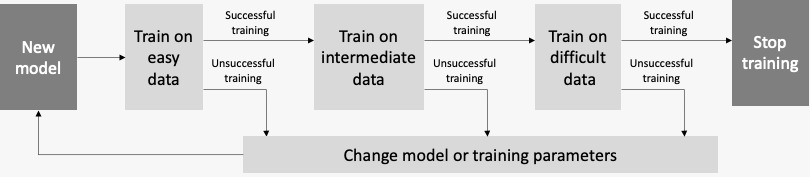


We divided it to blocks for convenience.

For Basic data sets

In [ ]:
from google.colab import drive
import scipy.io 
drive.mount('/content/gdrive')
train_set = scipy.io.loadmat('/content/gdrive/My Drive/Colab Notebooks/Project/data/videos_train.mat')
validation_set = scipy.io.loadmat('/content/gdrive/My Drive/Colab Notebooks/Project/data/videos_validation.mat')
test_set = scipy.io.loadmat('/content/gdrive/My Drive/Colab Notebooks/Project/data/videos_test.mat')

For Intermediate-Basic data sets

In [ ]:
from google.colab import drive
import scipy.io 
drive.mount('/content/gdrive')
train_set = scipy.io.loadmat('/content/gdrive/My Drive/Colab Notebooks/Project/data/videos_train_basic_intermediate_5k_1.mat')
validation_set = scipy.io.loadmat('/content/gdrive/My Drive/Colab Notebooks/Project/data/videos_validation_basic_intermediate_2k_1.mat')
test_set = scipy.io.loadmat('/content/gdrive/My Drive/Colab Notebooks/Project/data/videos_test_basic_intermediate_2k_1.mat')

For difficult data sets

In [ ]:
from google.colab import drive
import scipy.io 
drive.mount('/content/gdrive')
train_set = scipy.io.loadmat('/content/gdrive/My Drive/Colab Notebooks/Project/data/videos_train_difficult_5k_1.mat')
validation_set = scipy.io.loadmat('/content/gdrive/My Drive/Colab Notebooks/Project/data/videos_validation_difficult_2k_1.mat')
test_set = scipy.io.loadmat('/content/gdrive/My Drive/Colab Notebooks/Project/data/videos_test_only_difficult_1k_1.mat')

Setting up the train, validation, and test data sets. Since we wanted to work with weights centered around 0, we also normalized all the images to [-0.5,0.5]

In [ ]:
train_data_list = list(train_set.items())
train_array = np.array(train_data_list)
del train_data_list  # To save RAM
train_data = train_array[3][1] # The actual data without redundancies
train_data = train_data.astype(np.float)
train_data -= 0.5 # Normalizing data to [-0.5,0.5]

In [ ]:
validation_data_list = list(validation_set.items())
validation_array = np.array(validation_data_list)
del validation_data_list
validation_data = validation_array[3][1] # The actual data without redundancies
validation_data = validation_data.astype(np.float)
validation_data -= 0.5 # Normalizing data to [-0.5,0.5]

In [ ]:
test_data_list = list(test_set.items())
test_array = np.array(test_data_list)
del test_data_list
test_data = test_array[3][1] # The actual data without redundancies
test_data = test_data.astype(np.float)
test_data -= 0.5 # Normalizing data to [-0.5,0.5]

The original datasets is organized in a 4 dimensional matrix with the following structure: [video index, frame index, height, width], this structure support training of videos. 

In order to train the Autoencoder’s ability to encode and decode each frame, we reorganized our data into a 3 dimensional matrix with the following structure: [frame index, height, width], where the first dimension contains all frames from all videos. That way, we could treat every frame by its own.

In [ ]:
(num_videos,num_frames) = np.shape(train_data)[0:2] 
train_data_ae = np.reshape(train_data,(num_videos*num_frames,48,48)) # The new matrix should be ((number of videos)*(number of frames), 48, 48)
print("shape before reshape:", np.shape(train_data)) 
print("shape after reshape:",np.shape(train_data_ae))

shape before reshape: (5000, 30, 48, 48)
shape after reshape: (150000, 48, 48)


In [ ]:
(num_videos,num_frames) = np.shape(validation_data)[0:2] 
validation_data_ae = np.reshape(validation_data,(num_videos*num_frames,48,48)) # The new matrix should be ((number of videos)*(number of frames), 48, 48)
print("shape before reshape:", np.shape(validation_data)) 
print("shape after reshape:",np.shape(validation_data_ae))

shape before reshape: (2000, 30, 48, 48)
shape after reshape: (60000, 48, 48)


In [ ]:
(num_videos,num_frames) = np.shape(test_data)[0:2] 
test_data_ae = np.reshape(test_data,(num_videos*num_frames,48,48)) # The new matrix should be ((number of videos)*(number of frames), 48, 48)
print("shape before reshape:", np.shape(test_data)) 
print("shape after reshape:",np.shape(test_data_ae))

shape before reshape: (1000, 30, 48, 48)
shape after reshape: (30000, 48, 48)


Let's see what this data looks like:

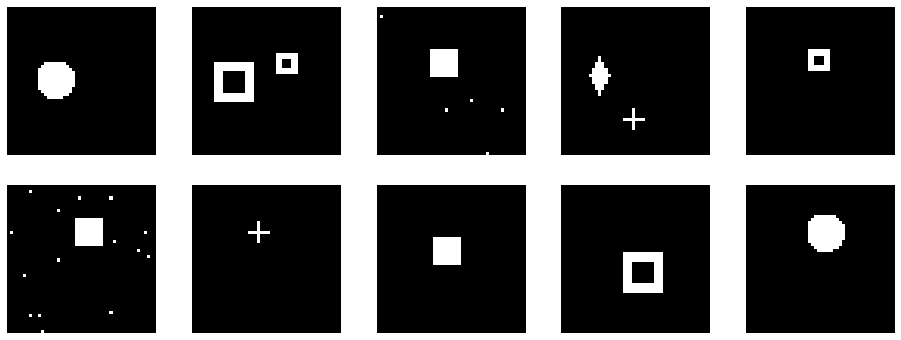

In [ ]:
plt.figure(figsize=(16, 6))
index_to_check = 75
for i in range(index_to_check,index_to_check+10):
    plt.subplot(2, 5, i-index_to_check + 1)
    image = train_data[i,11]
    plt.imshow(image, cmap='Greys_r')
    plt.axis('off');

# AutoEncoder Model
The autoencoder we are implementing is comprised of convolutions and linear layers. Therefore, after the convolution layers the dimensionality reduction is obtained from the usage of stride that is larger than one. 

In order to evaluate the models accuracies, we measured the MSE distance between the input and the output images.
We measured this MSE distance to the input image twice: once with the raw output of the model, and second, after binarization of the output of the model to -0.5 and 0.5 values, corresponding to the input image range.
Both measures presented in the training graphs, and we can constantly see that the after binarization graph is following the pre-binarization graph (in a small gap, since a weights need to “cross the zero” in order to reduce the after binarization MSE).

We'll show the process we went through in order to get to a good Autoencoder architecture: 
First, we tried an architecture for MNIST dataset, which is comprised of convolution and deconvolution layers only, to see if it works for our model:

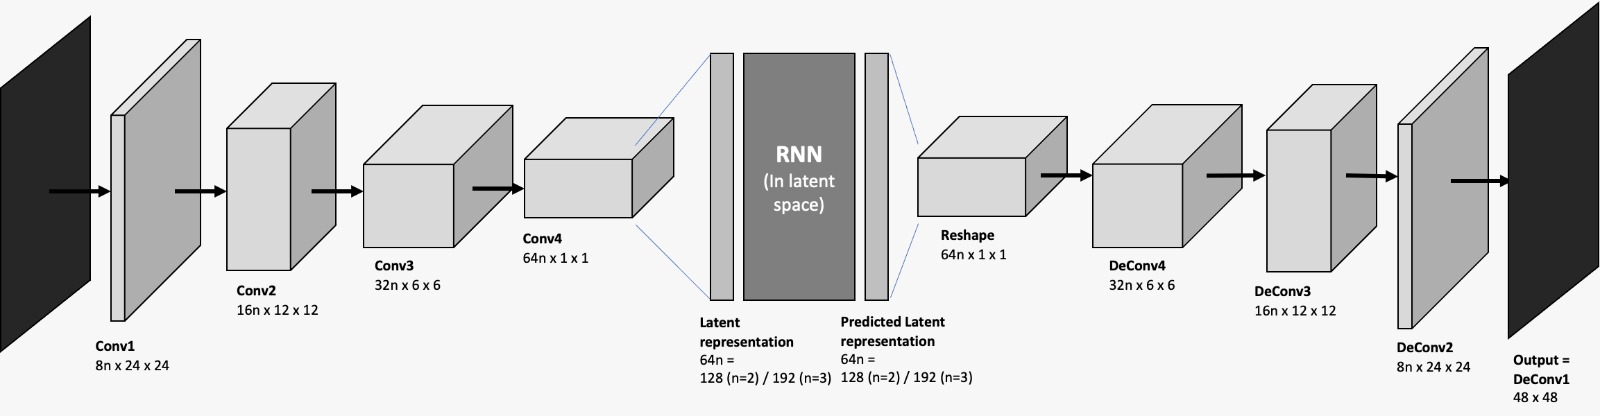

The activation function we used in this model was Tanh, that outputs values from -1 to 1. Therfore, the output of our model wasn't in the same range of the input images, so we got large MSE difference :  

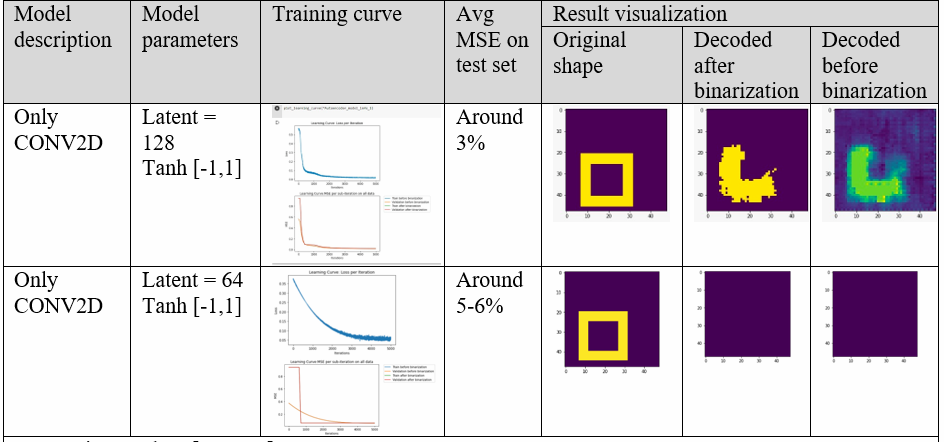

Note: for some small shapes, the model even choose to output a zero-image due to the small differences (most of the pixels are 0's and very few are 1's).

After changing the range of the activation function (adding a divide by 2 layer to the network) we got slightly better result:

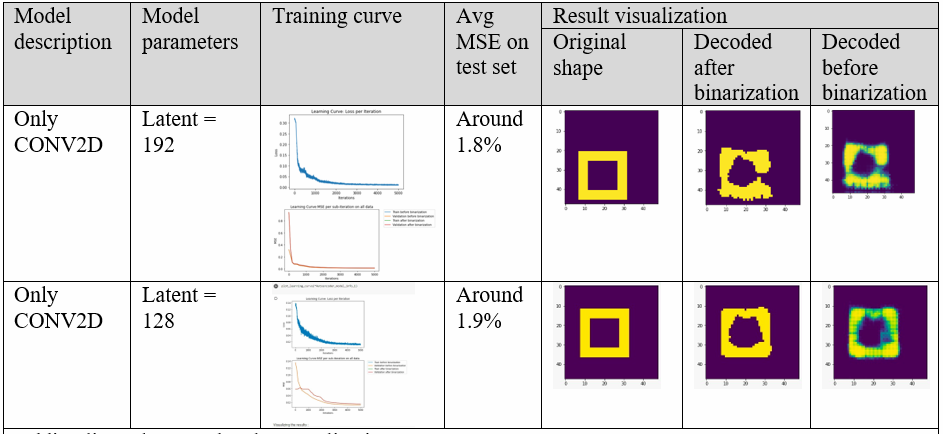

Since the decoded image's resolution wasn't good enough, after searching online for some architecture upgrades, we tried adding linear layers and batch normalizations, to increase the model's ability to learn:

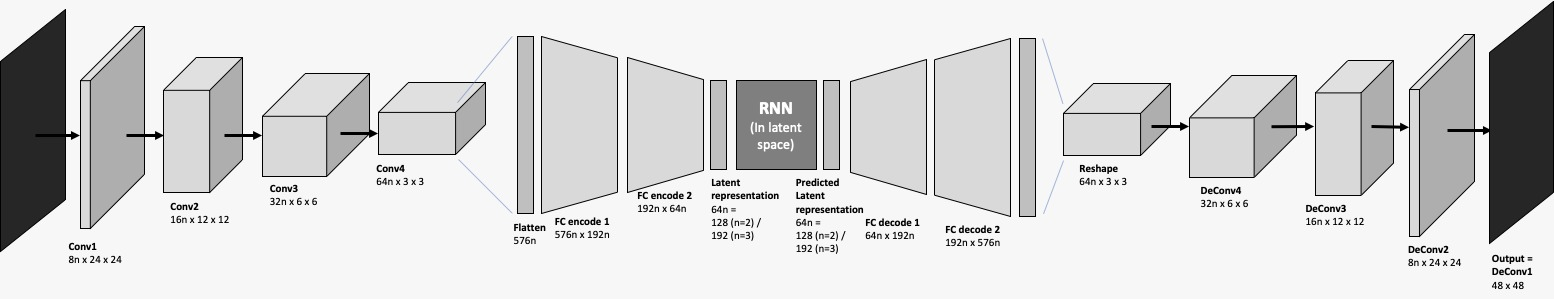

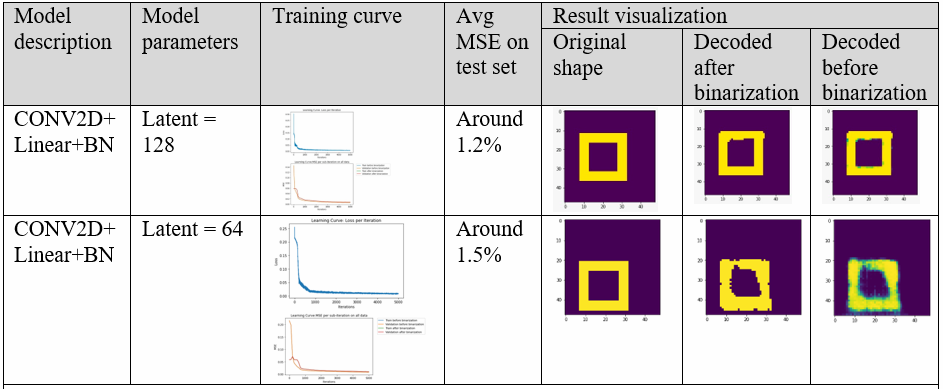



Since the resolution problem wasn’t fixed using the linear layers and batch normalization, we tried a different approach.
After research, we found online the concept of “skip connections” between the encoder and the decoder, that in particular skips the bottleneck, for enhancing output resolution.
The concept is presented in this link, for example:
https://towardsdatascience.com/using-skip-connections-to-enhance-denoising-autoencoder-algorithms-849e049c0ac9

In our case, we couldn’t implement exactly the same concept since we are also interested in creating a bottleneck.
We tried building an architecture that based on the concept above, with creating the latent as a concatenation of 2 vectors - The regular latent, and a latent coming from the early stages of the network and added to the last layers, and considered as the “skipping latent”.

This “skipping latent” contains linear layers for fitting the connection layers dimensions.

The architecture we tried is illustrated below:

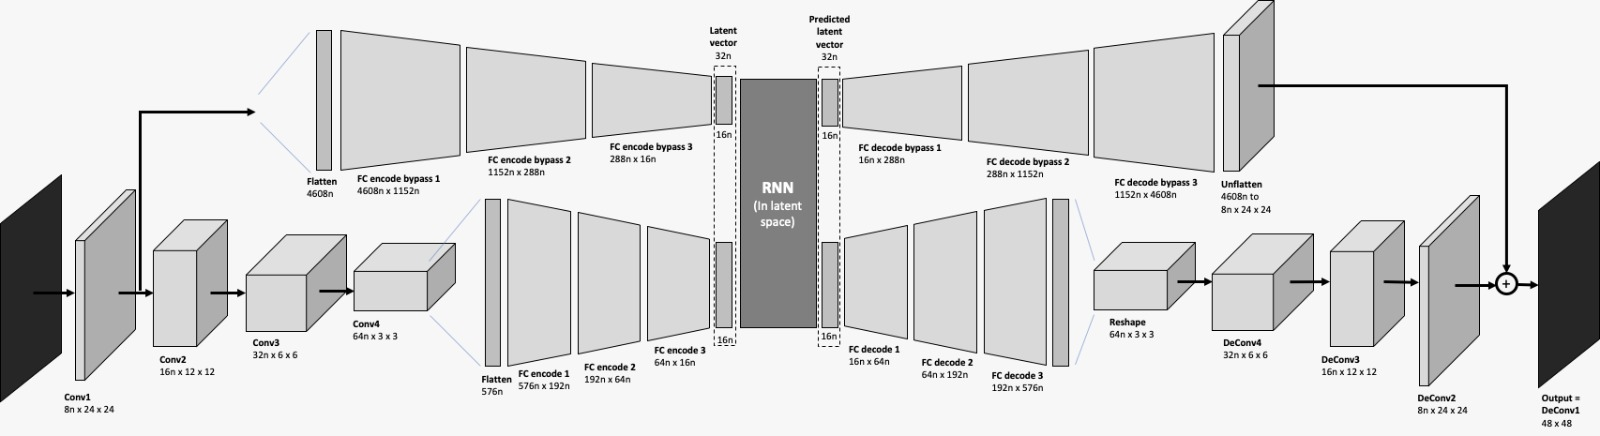

The model was slow to train, due to the massive addition of weights, and didn't make the resolution upgrads that we hoped for. 

We also tried changing the loss function in order to improve the small details of the decoder, such as: Cross-Entropy, IOU and MSE. We also tried combaining them which resulted with some unsucceseful outcomes:
Since we wanted to punish the model for the bad edges of the decoded image ,we tried to combine IoU loss with the loss formula: loss = MSE + lambda*IoU
The result for latent=128 was good loss optimization but bad visual performance:


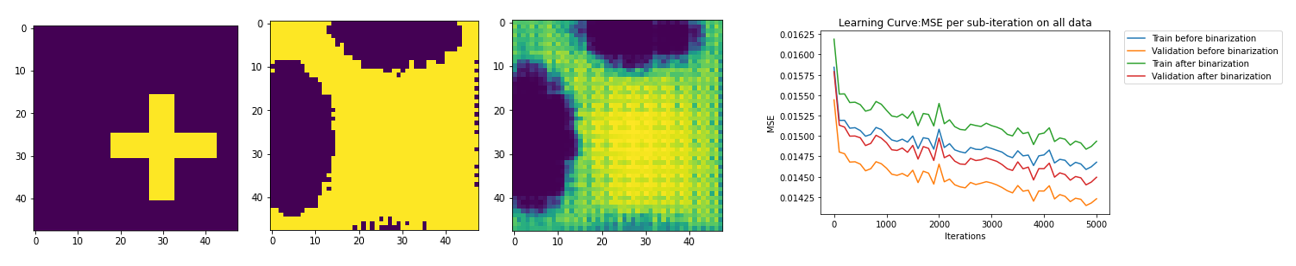

Final model:

After trying bunch of architectures we increased the size of the image after deconvolution (we increase by 2: 96X96) and then use convolution again in order to reduce the image to it's original shape. Using this architecture we managed to deal better with the resolution problem. After many Epochs, we got great accuracy in the Autodecode stage : about 0.4 % error. 

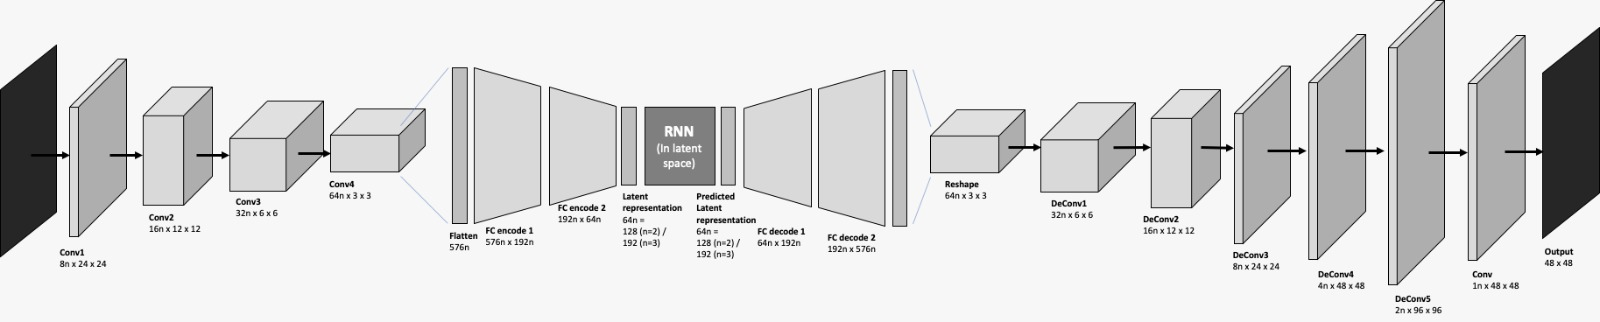

The final model is selected with the parameter n=1, which yields latent size of 64.

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self,n=1): 
        # n= 1,2,3 ; for n=1 => 64x1 vector, n=2 => 128x1 vector, n=3 => a 256x1 vector in the latent space
        super(Autoencoder, self).__init__()
        self.n=n
         ## Convolution layer      (100 , 1, 48, 48)
        self.conv2d_1 = nn.Conv2d(1, 8*n, 3, stride=2, padding=1)
         # (8n ,24 ,24)
        self.conv2d_2 = nn.Conv2d(8*n, 16*n, 3, stride=2, padding=1)
         # (16n ,12 ,12)
        self.conv2d_3 = nn.Conv2d(16*n, 32*n, 3, stride=2, padding=1)
         # (32n ,6 ,6)
        self.conv2d_4 = nn.Conv2d(32*n, 64*n, 3, stride=2, padding=1) 
         # (64n ,3 , 3)

         # Batch Normalization layer
        self.Batch_norm2d_1 = nn.BatchNorm2d(16*n)
         
        # None-linear activation function
        self.relu_layer = nn.ReLU()

        ## Flatten layer
        self.flatten_layer=nn.Flatten(start_dim=1) # (576n)
        ## Linear layer for encoder
        self.fc_encode_1 = nn.Linear(576*n, 192*n)
        self.fc_encode_2 = nn.Linear(192*n, 64*n)  
        ## Linear layer for decoder
        self.fc_decode_2 = nn.Linear(64*n,192*n)
        self.fc_decode_3 = nn.Linear(192*n,64*n * 3 * 3)
        ## Unflatten layer
        self.unflatten_layer = nn.Unflatten(dim=1, unflattened_size=(64*n, 3, 3))
        ## Deconvolution layer
        self.deconv2d_1 = nn.ConvTranspose2d(64*n,32*n, 3, stride=2, padding=1, output_padding=1)
        # Batch Normalization layer
        self.Batch_norm2d_2 = nn.BatchNorm2d(32*n)
        # (32n ,6 ,6)
        self.deconv2d_2 = nn.ConvTranspose2d(32*n,16*n, 3, stride=2, padding=1, output_padding=1)
        # (16n ,12 ,12)
        self.deconv2d_3 = nn.ConvTranspose2d(16*n,8*n, 3, stride=2, padding=1, output_padding=1)
        # (8n ,24 ,24)
        self.Batch_norm2d_4 = nn.BatchNorm2d(8*n)
        self.deconv2d_4 = nn.ConvTranspose2d(8*n, 4*n, 3, stride=2, padding=1, output_padding=1)
        # (4*n ,48 ,48)
        self.deconv2d_5 = nn.ConvTranspose2d(4*n, 2*n, 3, stride=2, padding=1, output_padding=1)
        # (2*n ,96 ,96)
        self.reconv2d = nn.Conv2d(2*n, 1, 3, stride=2, padding=1) 
        # (1 ,48 ,48)
        # Activation
        self.tanh_layer = nn.Tanh()   # the result is between -1 to 1
        
    def encoder(self, x):
      x = self.conv2d_1(x)
      x = self.relu_layer(x)
      x = self.conv2d_2(x)
      x = self.Batch_norm2d_1(x)
      x = self.relu_layer(x)
      x = self.conv2d_3(x)
      x = self.relu_layer(x)
      x = self.conv2d_4(x)
      x = self.flatten_layer(x)
      x = self.fc_encode_1(x)
      x = self.relu_layer(x)
      x = self.fc_encode_2(x) 
      return x

    def decoder(self, x):
      x = self.fc_decode_2(x)
      x = self.relu_layer(x)
      x = self.fc_decode_3(x)
      x = self.unflatten_layer(x)
      x = self.deconv2d_1(x)
      x = self.Batch_norm2d_2(x)
      x = self.relu_layer(x)
      x = self.deconv2d_2(x)
      x = self.relu_layer(x)
      x = self.deconv2d_3(x)
      x = self.Batch_norm2d_4(x)
      x = self.relu_layer(x)
      x = self.deconv2d_4(x)
      x = self.relu_layer(x)
      x = self.deconv2d_5(x)
      x = self.relu_layer(x)
      x = self.reconv2d(x)
      x = self.tanh_layer(x)
      x = x/2
      return x
      
    def forward(self, x):
      # Encoding
      x = self.encoder(x)
      # Decoding
      x = self.decoder(x)
      return x

# Training Section Of the AutoEncoder
As we explained before, we'll use the MSE loss, applied to the input and the output, with and without binarization.

In [ ]:
def get_MSE(model, data, batch_size=100):
    """Compute the model's MSE on the full data set. This function returns
    the model's MSE with and without binarization.

    Example Usage:

    >>> model = CNN() # create untrained model
    >>> MSE_before_binarization,MSE_after_binarization = get_MSE(model,data, valid_data,batch_size)

    """
    model.eval()
    n = data.shape[0]

    MSE_measure_before_bin = 0
    MSE_measure_after_bin = 0
    num_of_batches = 0
    for i in range(0, n, batch_size):

        if (i + batch_size) > n:
            break
        num_of_batches = num_of_batches + 1
        train_batch = torch.Tensor(data[i:i+batch_size,:,:])
        train_batch = torch.unsqueeze(train_batch,1)
        decoded_data = model(train_batch)
        # casting to numpy arrays
        decoded_data = decoded_data.detach().numpy()
        train_batch = train_batch.detach().numpy()

        # Calculating MSE before binarization
        diff = decoded_data-train_batch
        diff = diff.reshape(-1) # Making a row vector
        diff = diff**2
        MSE_measure_per_batch = np.mean(diff) 
        MSE_measure_before_bin = MSE_measure_before_bin + MSE_measure_per_batch
        
        # binarization of the decoded data to {-0.5,0.5}
        binarized_decoded_data = np.sign(decoded_data)/2
        diff = binarized_decoded_data-train_batch
        diff = diff.reshape(-1) # Making a row vector
        diff = diff**2
        MSE_measure_per_batch = np.mean(diff) 
        MSE_measure_after_bin = MSE_measure_after_bin + MSE_measure_per_batch 

    return MSE_measure_before_bin/num_of_batches, MSE_measure_after_bin/num_of_batches

In [ ]:
def train_model(model,
                      train_data=train_data_ae,
                      validation_data=validation_data_ae,
                      batch_size=100,
                      learning_rate=0.001,
                      weight_decay=0,
                      max_iters=1000,
                      checkpoint_path=None):
 
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(),
                           lr=learning_rate,
                           weight_decay=weight_decay)

    
    iters, losses = [], []
    iters_sub, train_MSE_before_bin_arr,train_MSE_after_bin_arr  = [], [] ,[]
    valid_MSE_before_bin_arr,valid_MSE_after_bin_arr = [], []
    model = model.float()

    n = 0 # the number of iterations
    epoch = 0
    while True:
        np.random.shuffle(train_data)

        for i in range(0, train_data.shape[0],batch_size ):
            if (i + batch_size) > train_data.shape[0]:
                break

            # get the input and targets of a minibatch
            train_batch = train_data[i:batch_size + i,:,:]

            # convert from numpy arrays to PyTorch tensors
            train_batch_tensor = torch.Tensor(train_batch)
            train_batch_tensor = torch.unsqueeze(train_batch_tensor,1)
            batch_result = model.forward(train_batch_tensor)           # compute encoder-decoded data
            loss = criterion(train_batch_tensor,batch_result)  # compute the total loss
            optimizer.zero_grad()                                      # a clean up step for PyTorch
            loss.backward()                                            # compute updates for each parameter
            optimizer.step()                                           # make the updates for each parameter

            # save the current training information
            iters.append(n)
            losses.append(float(loss))  # compute *average* loss
            if n % 250 == 0:
              iters_sub.append(n)
              train_cost = float(loss.detach().numpy())
              train_MSE_before_bin,train_MSE_after_bin= get_MSE(model, train_data[0:3000,:,:], batch_size)  # We measure only on subset of the train in order to speedup the training phase 
              vaid_MSE_before_bin,vaid_MSE_after_bin = get_MSE(model, validation_data, batch_size)
              # Appending all MSE's
              train_MSE_before_bin_arr.append(train_MSE_before_bin)
              train_MSE_after_bin_arr.append(train_MSE_after_bin)
              valid_MSE_before_bin_arr.append(vaid_MSE_before_bin)
              valid_MSE_after_bin_arr.append(vaid_MSE_after_bin)

              print("Epoch:",epoch,"Iter:",n,"Train MSE Before Binarization:", train_MSE_before_bin,"Train MSE after Binarization:",train_MSE_after_bin)
              print("Val MSE Before Binarization:",vaid_MSE_before_bin,"Val MSE after Binarization:",vaid_MSE_after_bin)
              print("The loss of the current batch is:", train_cost)
              print("---------------------------------------------------------------------------------------")

            # increment the iteration number
            n += 1

            # check point of the last iteration
            if (checkpoint_path is not None) and n > 0 and n==max_iters:
              torch.save(model.state_dict(), checkpoint_path.format(n))

            if n > max_iters:
                return iters, losses, iters_sub, train_MSE_before_bin_arr, train_MSE_after_bin_arr,valid_MSE_before_bin_arr,valid_MSE_after_bin_arr
            
        # End of every Epoch
        print("End of Epoch:", epoch)

        # increment the Epoch number
        epoch+=1

        if (checkpoint_path is not None) and n > 0:
            torch.save(model.state_dict(), checkpoint_path.format(n))


def plot_learning_curve(iters, losses, iters_sub, train_MSE_before_bin_arr, train_MSE_after_bin_arr,valid_MSE_before_bin_arr,valid_MSE_after_bin_arr):
    """
    Plot the learning curve.
    """
    plt.title("Learning Curve: Loss per Iteration")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Learning Curve:MSE per sub-iteration on all data")
    plt.plot(iters_sub, train_MSE_before_bin_arr, label="Train before binarization")
    plt.plot(iters_sub, valid_MSE_before_bin_arr, label="Validation before binarization")

    plt.plot(iters_sub, train_MSE_after_bin_arr, label="Train after binarization")
    plt.plot(iters_sub, valid_MSE_after_bin_arr, label="Validation after binarization")
    plt.xlabel("Iterations")
    plt.ylabel("MSE")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.show()


Training of the model, in case we don't want to load weights:

Note: We trained both models while gradually changing the Learning rates. We noticed that lr= 2e-4 works best for us, and in later trainings we decreased the lr in order to maximize the accuracies.

The importance of low MSE in the AE part is high, since the amount of different pixels = MSE * (dimensions of the image) , in binarized images

In [ ]:
Autoencoder_model = Autoencoder(n=1) 
check_point_path_1 = '/content/gdrive/My Drive/Colab Notebooks/Project/check_points/check_p1/ckpt-{}.pk'
Autoencoder_model_info_1 =   train_model(Autoencoder_model,
                                  train_data=train_data_ae[:,:,:],
                                  validation_data=validation_data_ae,
                                  batch_size=100,
                                  learning_rate=5e-5,
                                  weight_decay=0,
                                  max_iters=5000,
                                  checkpoint_path=check_point_path_1)


Epoch: 0 Iter: 0 Train MSE Before Binarization: 0.0028570513629044094 Train MSE after Binarization: 0.003277633098574976
Val MSE Before Binarization: 0.0040229813845265505 Val MSE after Binarization: 0.004681618926248726
The loss of the current batch is: 0.002715974347665906
---------------------------------------------------------------------------------------
Epoch: 0 Iter: 250 Train MSE Before Binarization: 0.0028335812035948037 Train MSE after Binarization: 0.0032478298681477705
Val MSE Before Binarization: 0.004023719829116696 Val MSE after Binarization: 0.004683579283373547
The loss of the current batch is: 0.0028349380008876324
---------------------------------------------------------------------------------------
Epoch: 0 Iter: 500 Train MSE Before Binarization: 0.0028531777982910476 Train MSE after Binarization: 0.0032735821713383
Val MSE Before Binarization: 0.004031778700179226 Val MSE after Binarization: 0.004694024882289038
The loss of the current batch is: 0.0031854587141

In case we want to load weights:

In [ ]:
Autoencoder_model = Autoencoder(n=1) 
# checkpoint_path = '/content/gdrive/My Drive/Colab Notebooks/Project/check_points/check_p1/ckpt-5000.pk' 
checkpoint_path = '/content/gdrive/My Drive/Colab Notebooks/Project/check_points/best_AE/ckpt-5000.pk' 
Autoencoder_model.load_state_dict(torch.load(checkpoint_path))
Autoencoder_model.eval()

Plotting results:

In [ ]:
plot_learning_curve(*Autoencoder_model_info_1)


Visualizing the Autoencoder's results:

In [ ]:
Autoencoder_model.eval()
test_data_ae_batch = test_data_ae[::10,:,:]
test_data_ae_tesor = torch.Tensor(test_data_ae_batch) # (30000, 48, 48)
test_data_ae_tesor = torch.unsqueeze(test_data_ae_tesor,1) # (30000,1 , 48, 48)
decoded_test_data = Autoencoder_model(test_data_ae_tesor)
# casting to numpy arrays
decoded_test_data = torch.squeeze(decoded_test_data,1)
decoded_test_data = decoded_test_data.detach().numpy()
binarized_decoded = np.sign(decoded_test_data)*0.5 +0.5

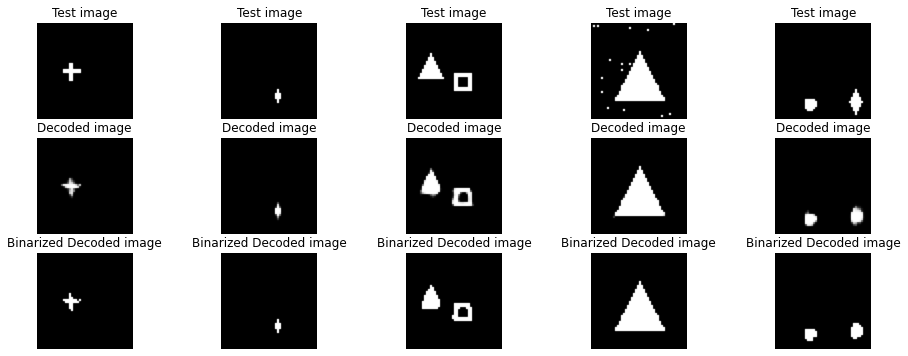

In [ ]:
plt.figure(figsize=(16, 6))
index_to_check = 0
amount_of_imgs = 5
start_idx = 80
skip_idx = 10
for i in range(0,amount_of_imgs):
    img_idx = start_idx + i*skip_idx
    plt.subplot(3,amount_of_imgs, i + 1)
    image = test_data_ae_batch[img_idx]
    plt.imshow(image, cmap='Greys_r')
    plt.title('Test image')
    plt.axis('off');
    plt.subplot(3,amount_of_imgs, i + amount_of_imgs + 1)
    image = decoded_test_data[img_idx]
    plt.imshow(image, cmap='Greys_r')
    plt.title('Decoded image')
    plt.axis('off');
    plt.subplot(3,amount_of_imgs, i + 2*amount_of_imgs + 1)
    image = binarized_decoded[img_idx]
    plt.imshow(image, cmap='Greys_r')
    plt.title('Binarized Decoded image')
    plt.axis('off');

# Latent Prediction Model
The Latent Prediction model receives 5 latent representation of 5 input frames and outputs 1 latent vector, which represents the next frame.

First, let's arrange the data into videos (sets of frames):

We'll not be using all 30 frames of each video, but only 6 frames (taking every 5th frame), and the last one is the target frame. There are couple of reasons for that :


*   Since the changes between consecutive frames is small, using all 29 frames to predict the 30th might be easy. In order to make it harder for the model, make predictions using limited amount of frames.
*   From the same reasons, the target frame might be similar to the 29th frame so the model tends to predict an image similar to the 29th frame instead of understanding the movement of the shapes.
*   RNN based models might have difficulties handling long term memory, so using limited amount of frames could make training easier. 



In [ ]:
frames_gap = 5 # Define the length of the input video to [30/frames_gap] frames (for frame_gap=1, the input video is 30 frames. for frame_gap=2, the input video is 15 frames)

In [ ]:
train_data_rnn = train_data[:,::frames_gap,:,:] # The new matrix should be ((number of videos)*(number of frames), 48, 48)
print("shape:", np.shape(train_data_rnn)) 

shape: (5000, 6, 48, 48)


In [ ]:
validation_data_rnn = validation_data[:,::frames_gap,:,:] # The new matrix should be ((number of videos)*(number of frames), 48, 48)
print("shape:", np.shape(validation_data_rnn)) 

shape: (2000, 6, 48, 48)


In [ ]:
test_data_rnn = test_data[:,::frames_gap,:,:] # The new matrix should be ((number of videos)*(number of frames), 48, 48)
print("shape:", np.shape(test_data_rnn)) 

shape: (1000, 6, 48, 48)


We tried few models as the next latent predictor:



1.   LSTM based
2.   Fully connected layer based

We tried couple of architectures but these two achieved the lowest MSE.



**LSTM architecture:**

This model is constructed using 2 LSTM units stacked together and a linear layer. Due to applying linear layer on the output of the LSTM, we had a degree of freedom choosing the Hidden size of the LSTM units.

The evolution of the model :


*   Firstly, we tried 1 layer of LSTM without a linear layer (which constrained the hidden size to be equal to latent size, since the predicted latent is the last hidden vector). The results didn't converge well.
*   Adding a linear layer and changing the hidden size to 100. The results were much better but we felt that the model could be improved.
*   Lastly, adding another LSTM unit and increasing their hidden state size to 200 improved the MSE.

The architecture of the final model is illustrated below:

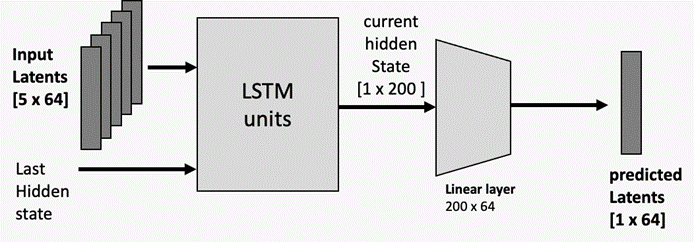

In [ ]:
class Frame_RNN(nn.Module):
    def __init__(self,n=4):
        super(Frame_RNN, self).__init__()
        self.input_size = 16*n
        self.hidden_size = 50*n     # second attempt -> hidden =200
        self.lstm = nn.LSTM(self.input_size, self.hidden_size, batch_first=True,num_layers=2)
        self.fc = nn.Linear(self.hidden_size, self.input_size)
        self.relu_layer = nn.ReLU()
    def forward(self, x):
        out, _ = self.lstm(x)
        # Relu layer
        out = self.relu_layer(out)
        # Pass the output of the last time step to the classifier
        out = self.fc(out)
        return out

**Fully connected model:**

As an alternative to the LSTM model, we proposed another model which is constructed by 2 linear layers.
In this model, the input is 320x1 vector which is 5 latents concatenated.  

The architecture of the final model is illustrated below:

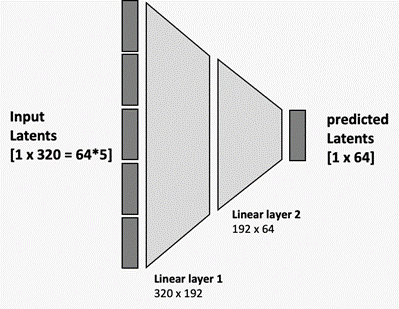

In [ ]:
class LatentPredictor(nn.Module):
    def __init__(self,n=2): 
      # n= 1,2,3 ; for n=1 => 16x1 vector, n=2 => 32x1 vector , n=3 => 
      super(LatentPredictor, self).__init__()
      self.n=n
      self.flatten_layer=nn.Flatten(start_dim=1) # (5*16*n)
      self.fc_1 = nn.Linear(5*16*n, 3*16*n)
      self.fc_2 = nn.Linear(3*16*n, 16*n)
      self.relu_layer = nn.ReLU()

    def forward(self, x):
      x = self.flatten_layer(x)
      x = self.fc_1(x)
      x = self.relu_layer(x)
      x = self.fc_2(x)
      x = torch.unsqueeze(x,1)
      return x

In the training of the next latent representation, we measure accuracy of the output latent by comparing the output latent to the latent of the groud truth frame (to do that, we encoded the ground truth frame and then compared) by MSE manner.

In [ ]:
def get_RNN_MSE(rnn_model,ae_model, data, batch_size=100):
    """Compute the model's MSE on the full data set. This function returns
    the model's MSE between the ground-truth and the predicted latent
    """
    rnn_model.train()
    ae_model.eval()

    n = data.shape[0]
    num_of_frames = data.shape[1]
    MSE_measure = 0
    num_of_batches = 0
    for i in range(0, n, batch_size):

        if (i + batch_size) > n:
            break
        num_of_batches = num_of_batches + 1


        # get the input and targets of a minibatch
        video_batch = data[i:batch_size + i,:,:,:] # (batch_size, num_frames,48,48)

        # convert from numpy arrays to PyTorch tensors
        video_batch = np.reshape(video_batch,(batch_size*num_of_frames,1,48,48))
        batch_tensor = torch.Tensor(video_batch)

        # Passing to encoder
        latent_batch = ae_model.encoder(batch_tensor)   # compute encoded sequence. result is (batch_size, num_frames, latent_size)
        latent_batch = torch.reshape(latent_batch,(batch_size,num_of_frames,latent_batch.shape[1]))

        # Split to sequence_input and sequence_label
        input_seq_data_batch = latent_batch[:,:-1,:] # size (batch_size, all frames except last one, latent_size)
        input_seq_target_batch = latent_batch[:,-1,:] # size (batch_size, last frame, latent_size)

        # Predict the next latent
        pred_seq_result_all = rnn_model.forward(input_seq_data_batch) # size (batch_size, num_of_frames -1, latent_size)
        pred_seq_result = pred_seq_result_all[:,-1,:]                 # size (batch_size, 1, latent_size)
        # casting to numpy arrays
        input_seq_target_batch = input_seq_target_batch.detach().numpy()
        pred_seq_result = pred_seq_result.detach().numpy()

        # Calculating MSE
        diff = input_seq_target_batch-pred_seq_result
        diff = diff.reshape(-1) # Making a row vector
        diff = diff**2
        MSE_measure_per_batch = np.mean(diff) 
        MSE_measure = MSE_measure + MSE_measure_per_batch

    return MSE_measure/num_of_batches

In [ ]:
def train_RNN_model(rnn_model,ae_model,
                      train_data=train_data_rnn,
                      validation_data=validation_data_rnn,
                      batch_size=100,
                      learning_rate=0.001,
                      weight_decay=0,
                      max_iters=2000,
                      checkpoint_path=None):
 
    criterion_mse = nn.MSELoss()

    optimizer = optim.Adam(rnn_model.parameters(),
                           lr=learning_rate,
                           weight_decay=weight_decay)

    
    iters, losses = [], []
    iters_sub, train_MSE_arr, valid_MSE_arr  = [], [], []
    num_of_frames = train_data.shape[1]
    rnn_model = rnn_model.float()

    n = 0 # the number of iterations
    epoch = 0
    while True:
        np.random.shuffle(train_data)

        for i in range(0, train_data.shape[0],batch_size ):
            if (i + batch_size) > train_data.shape[0]:
                break

            # get the input and targets of a minibatch
            train_video_batch = train_data[i:batch_size + i,:,:,:] # (batch_size, num_frames,48,48)

            # convert from numpy arrays to PyTorch tensors
            train_video_batch = np.reshape(train_video_batch,(batch_size*num_of_frames,1,48,48))
            
            train_batch_tensor = torch.Tensor(train_video_batch)

            # train_batch_tensor = torch.unsqueeze(train_batch_tensor,1)
            train_latent_batch = ae_model.encoder(train_batch_tensor)   # compute encoded sequence. result is (batch_size, num_frames, latent_size)
            train_latent_batch = torch.reshape(train_latent_batch,(batch_size,num_of_frames,train_latent_batch.shape[1]))
            
            # Split to sequence_input and sequence_label
            input_seq_data_batch = train_latent_batch[:,:-1,:] # size (batch_size, all frames except last one, latent_size)
            input_seq_target_batch = train_latent_batch[:,-1,:] # size (batch_size, last frame, latent_size)

            # Predict the next latent
            pred_seq_result_all = rnn_model.forward(input_seq_data_batch) # size (batch_size, num_of_frames -1, latent_size)
            pred_seq_result = pred_seq_result_all[:,-1,:]                 # size (batch_size, 1, latent_size)

            # Training step
            loss = criterion_mse(pred_seq_result,input_seq_target_batch)
            optimizer.zero_grad()                              # a clean up step for PyTorch
            loss.backward()                                    # compute updates for each parameter
            optimizer.step()                                   # make the updates for each parameter

            # save the current training information
            iters.append(n)
            losses.append(float(loss))  # compute average loss

            # increment the iteration number
            n += 1

            # check point of the last iteration
            if (checkpoint_path is not None) and n > 0 and n==max_iters:
              torch.save(rnn_model.state_dict(), checkpoint_path.format(n))

            if n > max_iters:
                return iters, losses, iters_sub, train_MSE_arr,valid_MSE_arr
        
        iters_sub.append(n)
        train_cost = float(loss.detach().numpy())
        train_MSE = get_RNN_MSE(rnn_model, ae_model, train_data, batch_size)
        valid_MSE = get_RNN_MSE(rnn_model, ae_model, validation_data, batch_size)
        # Appending all MSE's
        train_MSE_arr.append(train_MSE)
        valid_MSE_arr.append(valid_MSE)

        print("Epoch:",epoch,"Iter:",n,"Train MSE:", train_MSE,"Val MSE:",valid_MSE,"Loss cur batch:", train_cost)
        print("---------------------------------------------------------------------------------------")

        # increment the Epoch number
        epoch+=1

        if (checkpoint_path is not None) and n > 0:
            torch.save(rnn_model.state_dict(), checkpoint_path.format(n))


def plot_RNN_learning_curve(iters, losses, iters_sub, train_MSE_arr,valid_MSE_arr):
    """
    Plot the learning curve.
    """
    plt.title("Learning Curve: Loss per Iteration")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Learning Curve:MSE per sub-iteration on all data")
    plt.plot(iters_sub, train_MSE_arr, label="Train")
    plt.plot(iters_sub, valid_MSE_arr, label="Validation")

    plt.xlabel("Iterations")
    plt.ylabel("MSE")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.show()

In case we want to train the Latent predictor:

LSTM model creation and training:

Below, we can see the last part of the training of the LSTM.

In [ ]:
# RNN_model = Frame_RNN(n=4) 
check_point_path_2 = '/content/gdrive/My Drive/Colab Notebooks/Project/check_points/lstm/2_lstm_layers/ckpt-{}.pk'
rnn_model_info_1 =   train_RNN_model(RNN_model,
                                  Autoencoder_model,
                                  train_data=train_data_rnn,
                                  validation_data=validation_data_rnn,
                                  batch_size=100,
                                  learning_rate=2e-4,
                                  weight_decay=0,
                                  max_iters=5000,
                                  checkpoint_path=check_point_path_2)

Epoch: 0 Iter: 50 Train MSE: 10.618664093017578 Val MSE: 12.886852931976318 Loss cur batch: 12.051980972290039
---------------------------------------------------------------------------------------
Epoch: 1 Iter: 100 Train MSE: 9.470700073242188 Val MSE: 12.096415138244629 Loss cur batch: 10.802905082702637
---------------------------------------------------------------------------------------
Epoch: 2 Iter: 150 Train MSE: 8.893415555953979 Val MSE: 11.83149585723877 Loss cur batch: 9.784614562988281
---------------------------------------------------------------------------------------
Epoch: 3 Iter: 200 Train MSE: 8.417025108337402 Val MSE: 11.642864751815797 Loss cur batch: 9.88714599609375
---------------------------------------------------------------------------------------
Epoch: 4 Iter: 250 Train MSE: 8.086110525131225 Val MSE: 11.50625 Loss cur batch: 10.80394172668457
---------------------------------------------------------------------------------------
Epoch: 5 Iter: 300 T

The training curve of the first training of the LSTM is illustrated below:

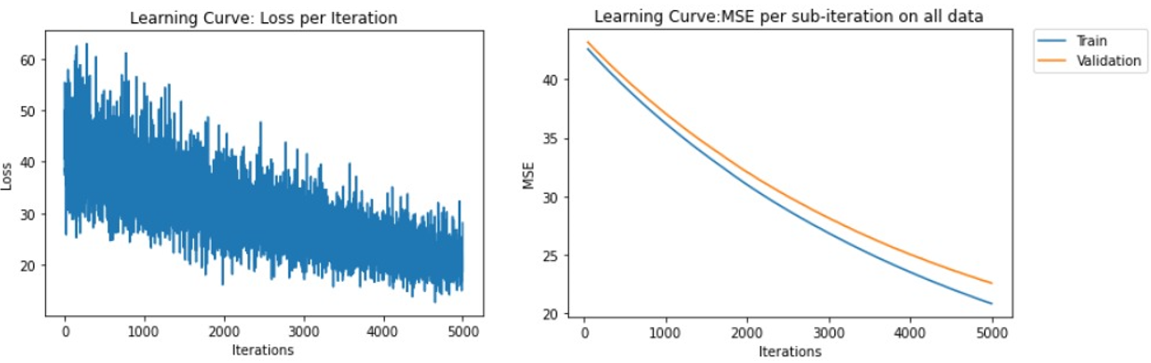

Linear predictor creation and training:

Below, we can see the last part of the training of the linear predictor.

In [ ]:
linear_predict_model = LatentPredictor(n=4)
check_point_path_2 = '/content/gdrive/My Drive/Colab Notebooks/Project/check_points/rnn/check_p1/ckpt-{}.pk'
linear_predict_model_info_1 =   train_RNN_model(linear_predict_model,
                                  Autoencoder_model,
                                  train_data=train_data_rnn,
                                  validation_data=validation_data_rnn,
                                  batch_size=100,
                                  learning_rate=2e-4,
                                  weight_decay=0,
                                  max_iters=5000,
                                  checkpoint_path=check_point_path_2)

Epoch: 0 Iter: 50 Train MSE: 8.823971176147461 Val MSE: 9.66433744430542 Loss cur batch: 9.17834758758545
---------------------------------------------------------------------------------------
Epoch: 1 Iter: 100 Train MSE: 8.552376708984376 Val MSE: 9.498547697067261 Loss cur batch: 9.02035903930664
---------------------------------------------------------------------------------------
Epoch: 2 Iter: 150 Train MSE: 8.345735025405883 Val MSE: 9.416462755203247 Loss cur batch: 8.467401504516602
---------------------------------------------------------------------------------------
Epoch: 3 Iter: 200 Train MSE: 8.202371187210083 Val MSE: 9.30011773109436 Loss cur batch: 8.129308700561523
---------------------------------------------------------------------------------------
Epoch: 4 Iter: 250 Train MSE: 7.98969292640686 Val MSE: 9.155958223342896 Loss cur batch: 7.957297325134277
---------------------------------------------------------------------------------------
Epoch: 5 Iter: 300 Tr

In [ ]:
plot_RNN_learning_curve(*rnn_model_info_1)

Learning Curve of the last train of the linear latent predictor:

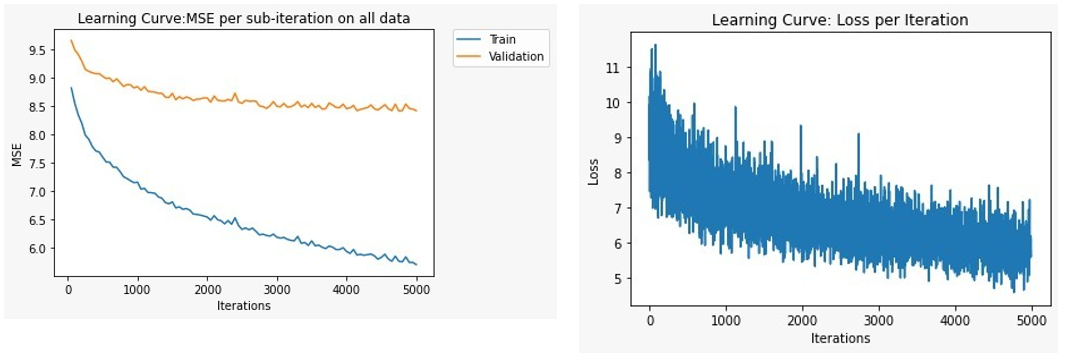

Loading weights of the LSTM model:

In [ ]:
RNN_model = Frame_RNN(n=4)
# checkpoint_path = '/content/gdrive/My Drive/Colab Notebooks/Project/check_points/new_arc_n=2_lr=0.0002/ckpt-5000.pk' 
# checkpoint_path = '/content/gdrive/My Drive/Colab Notebooks/Project/check_points/lstm/hidden_200/ckpt-5000.pk'
checkpoint_path = '/content/gdrive/My Drive/Colab Notebooks/Project/check_points/lstm/2_lstm_layers/ckpt-3800.pk'
RNN_model.load_state_dict(torch.load(checkpoint_path))

<All keys matched successfully>

Loading weights of the linear predictor model :

In [ ]:
linear_predict_model = LatentPredictor(n=4)
# checkpoint_path = '/content/gdrive/My Drive/Colab Notebooks/Project/check_points/new_arc_n=2_lr=0.0002/ckpt-5000.pk' # Update me
checkpoint_path = '/content/gdrive/My Drive/Colab Notebooks/Project/check_points/rnn/check_p1/ckpt-5000.pk' # Update me
linear_predict_model.load_state_dict(torch.load(checkpoint_path))


<All keys matched successfully>

**Conclusions from the latent predictor training:**

As we can see, based on the MSE, both models managed to predict pretty well with relatively same MSE. Yet, the Linear latent predictor managed to get better results with predicting the next latent.
Furthermore, the difference of the MSE between the train and validation was minor all along, using the linear predictor. That can point out that perhaps, the linear model generalized the data structure better than the LSTM model. 

Based on these conclusions, we choose to use the linear predictor rather than the LSTM for the final model.

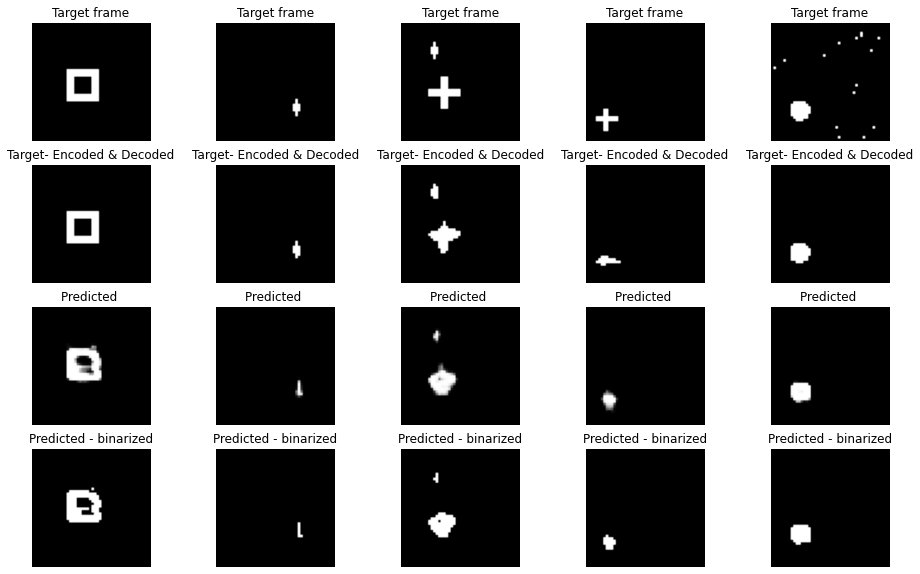

In [ ]:
plt.figure(figsize=(16, 10))
index_to_check = 0
amount_of_imgs = 5
start_idx = 35
skip_idx = 4
for i in range(0,amount_of_imgs):
    video_index = start_idx + i*skip_idx

    # get the input and targets of a minibatch
    test_video_batch = test_data_rnn[video_index,:,:,:] # (batch_size, num_frames,48,48)
    num_of_frames = test_video_batch.shape[0]
    # convert from numpy arrays to PyTorch tensors
    train_video_batch = np.reshape(test_video_batch,(num_of_frames,1,48,48)) # (6,1,48,48)
    Autoencoder_model.eval()
    test_batch_tensor = torch.Tensor(test_video_batch)
    test_batch_tensor = torch.unsqueeze(test_batch_tensor,0)
    test_batch_tensor.transpose_(0, 1)
    test_latent_batch = Autoencoder_model.encoder(test_batch_tensor)   # compute encoded (6,64)
    test_latent_batch = torch.unsqueeze(test_latent_batch,0)
    predicted_next_latent = linear_predict_model.forward(test_latent_batch[:,:-1,:]) 
    predicted_next_latent = torch.squeeze(predicted_next_latent,0)

    decoded_frame = Autoencoder_model.decoder(predicted_next_latent)
    decoded_frame = torch.squeeze(decoded_frame,0)
    decoded_frame = torch.squeeze(decoded_frame,0)
    decoded_frame = decoded_frame.detach().numpy()
    decoded_frame_bin = np.sign(decoded_frame)*0.5 + 0.5

    undecoded_groundtruth = torch.Tensor(test_data_rnn[video_index,5,:,:])
    undecoded_groundtruth = torch.unsqueeze(undecoded_groundtruth,0)
    undecoded_groundtruth = torch.unsqueeze(undecoded_groundtruth,0)
    decoded_groundtruth = Autoencoder_model.forward(undecoded_groundtruth)
    decoded_groundtruth = torch.squeeze(decoded_groundtruth,0)
    decoded_groundtruth = torch.squeeze(decoded_groundtruth,0)
    decoded_groundtruth = decoded_groundtruth.detach().numpy()
    decoded_groundtruth = np.sign(decoded_groundtruth)*0.5 + 0.5

    plt.subplot(4,amount_of_imgs, i + 1)
    image = test_data_rnn[video_index,5,:,:]
    plt.imshow(image, cmap='Greys_r')
    plt.title('Target frame')
    plt.axis('off');
    plt.subplot(4,amount_of_imgs, i + amount_of_imgs + 1)
    image = decoded_groundtruth
    plt.imshow(image, cmap='Greys_r')
    plt.title('Target- Encoded & Decoded')
    plt.axis('off');
    plt.subplot(4,amount_of_imgs, i + 2*amount_of_imgs + 1)
    image = decoded_frame
    plt.imshow(image, cmap='Greys_r')
    plt.title('Predicted ')
    plt.axis('off');
    plt.subplot(4,amount_of_imgs, i + 3*amount_of_imgs + 1)
    image = decoded_frame_bin
    plt.imshow(image, cmap='Greys_r')
    plt.title('Predicted - binarized')
    plt.axis('off')

The plot above helps us to evaluate the weak points of our models:



*   The AE has a problem with small shapes.
*   The AE's ability to decode propertly shapes with fine details.
*   Although the linear predictor manages to predict the location of the shapes correctly, it adds distortions to most of the shapes.

We'll elaborate later on changes that might address these issues.

# End to End Train


Combining the AE model and the Latent predictor into a full system, in order to train both. The motivation to the last phase of training is adjusting both of the models, to increase their synergy.

In order to do that, we input 5 frames , encode them, predict the 6th latent and finally, decode it. We measure the loss between the decoded frame to the ground truth and back propagate thought both models, to update their weights.

In [ ]:
def end2end_MSE(ae_model,RNN_model, data, batch_size=100):
    """Compute the model's MSE on the full data set. This function returns
    the model's MSE with and without binarization.

    Example Usage:

    >>> model = CNN() # create untrained model
    >>> MSE_before_binarization,MSE_after_binarization = get_MSE(ae_model,RNN_model,data,batch_size)

    """
    ae_model.eval()
    RNN_model.eval()
    n = data.shape[0]
    num_of_frames = data.shape[1]

    MSE_measure_before_bin = 0
    MSE_measure_after_bin = 0
    num_of_batches = 0
    for i in range(0, n, batch_size):

        if (i + batch_size) > n:
            break
        num_of_batches = num_of_batches + 1


        # get the input and targets of a minibatch
        train_video_batch = data[i:batch_size + i,:,:,:] # (batch_size, num_frames,48,48)

        # Dividing the labels from batch
        train_video_batch_labels = train_video_batch[:,-1,:,:] # (batch_size, 1,48,48)
        train_video_batch = train_video_batch[:,:-1,:,:] # (batch_size, num_frames - 1,48,48)

        # Reshaping the train to (batch_size*(num_of_frames),1,48,48) and labels to (batch_size,1,48,48)
        train_video_batch_labels = np.reshape(train_video_batch_labels,(batch_size,1,48,48))
        train_video_batch = np.reshape(train_video_batch,((num_of_frames-1)*batch_size,1,48,48))

        # convert from numpy arrays to PyTorch tensors
        train_video_batch_labels_tensor = torch.Tensor(train_video_batch_labels)
        train_batch_tensor = torch.Tensor(train_video_batch)

        # Encoding the train data
        train_batch_latent = ae_model.encoder(train_batch_tensor) # Result's size is (batch_size*(num_of_frames),64)

        # Reshape for RNN to size : (btach_size,num_of_frames-1,latent)
        train_batch_latent = torch.reshape(train_batch_latent,(batch_size,(num_of_frames-1),train_batch_latent.shape[-1]))

        # RNN Forward result size is (batch_size,latent)
        train_batch_predicted = RNN_model.forward(train_batch_latent) 

        # Decode the prediction
        train_batch_predicted= torch.squeeze(train_batch_predicted,1)
        decoded_train_batch_predicted = ae_model.decoder(train_batch_predicted)

        # casting to numpy array
        decoded_train_batch_predicted = decoded_train_batch_predicted.detach().numpy()

        # Calculating MSE before binarization
        diff = decoded_train_batch_predicted-train_video_batch_labels
        diff = diff.reshape(-1) # Making a row vector
        diff = diff**2
        MSE_measure_per_batch = np.mean(diff) 
        MSE_measure_before_bin = MSE_measure_before_bin + MSE_measure_per_batch
        
        # binarization of the decoded data to {-0.5,0.5}
        binarized_decoded_data = np.sign(decoded_train_batch_predicted)/2
        diff = binarized_decoded_data-train_video_batch_labels
        diff = diff.reshape(-1) # Making a row vector
        diff = diff**2
        MSE_measure_per_batch = np.mean(diff) 
        MSE_measure_after_bin = MSE_measure_after_bin + MSE_measure_per_batch 

    return MSE_measure_before_bin/num_of_batches, MSE_measure_after_bin/num_of_batches

In [ ]:
def train_both(ae_model,
               RNN_model,
                      train_data=train_data_rnn,
                      validation_data=validation_data_ae,
                      batch_size=100,
                      learning_rate=0.001,
                      weight_decay=0,
                      max_iters=1000,
                      checkpoint_path_ae=None,
                      checkpoint_path_RNN=None):
  
    num_of_frames = train_data.shape[1]

    criterion = nn.MSELoss()
    params = list(ae_model.parameters())+list(RNN_model.parameters())
    optimizer = optim.Adam(params,
                           lr=learning_rate,
                           weight_decay=weight_decay)

    
    iters, losses = [], []
    iters_sub, train_MSE_before_bin_arr,train_MSE_after_bin_arr  = [], [] ,[]
    valid_MSE_before_bin_arr,valid_MSE_after_bin_arr = [], []

    ae_model = ae_model.float()
    RNN_model = RNN_model.float()

    n = 0 # the number of iterations
    epoch = 0
    while True:
        np.random.shuffle(train_data)

        for i in range(0, train_data.shape[0],batch_size ):
            if (i + batch_size) > train_data.shape[0]:
                break

            # get the input and targets of a minibatch
            train_video_batch = train_data[i:batch_size + i,:,:,:] # (batch_size, num_frames,48,48)

            # Dividing the labels from batch
            train_video_batch_labels = train_video_batch[:,-1,:,:] # (batch_size, 1,48,48)
            train_video_batch = train_video_batch[:,:-1,:,:] # (batch_size, num_frames - 1,48,48)

            # Reshaping the train to (batch_size*(num_of_frames-1),1,48,48) and labels to (batch_size,1,48,48)
            train_video_batch_labels = np.reshape(train_video_batch_labels,(batch_size,1,48,48))
            train_video_batch = np.reshape(train_video_batch,((num_of_frames-1)*batch_size,1,48,48))

            # convert from numpy arrays to PyTorch tensors
            train_video_batch_labels_tensor = torch.Tensor(train_video_batch_labels)
            train_batch_tensor = torch.Tensor(train_video_batch)

            # Encoding the train data
            train_batch_latent = ae_model.encoder(train_batch_tensor) # Result's size is (batch_size*(num_of_frames-1),64)

            # Reshape for RNN to size : (batch_size,num_of_frames-1,latent)
            train_batch_latent = torch.reshape(train_batch_latent,(batch_size,(num_of_frames-1),train_batch_latent.shape[-1]))

            # RNN Forward result size is (batch_size,latent)
            train_batch_predicted = RNN_model.forward(train_batch_latent) 

            # Decode the prediction ,result's size is: (batch_size,1,48,48)
            train_batch_predicted= torch.squeeze(train_batch_predicted,1)
            decoded_train_batch_predicted = ae_model.decoder(train_batch_predicted)

            loss = criterion(train_video_batch_labels_tensor,decoded_train_batch_predicted)  # compute the total loss
            optimizer.zero_grad()                                      # a clean up step for PyTorch
            loss.backward()                                            # compute updates for each parameter
            optimizer.step()                                           # make the updates for each parameter

            # save the current training information
            iters.append(n)
            losses.append(float(loss))  # compute *average* loss
            # if n % 250 == 0:
            # increment the iteration number
            n += 1

            # check point of the last iteration
            if (checkpoint_path_ae is not None) and n > 0 and n==max_iters:
              torch.save(ae_model.state_dict(), checkpoint_path_ae.format(n))

            if (checkpoint_path_RNN is not None) and n > 0 and n==max_iters:
              torch.save(RNN_model.state_dict(), checkpoint_path_RNN.format(n))

            if n > max_iters:
                return iters, losses, iters_sub, train_MSE_before_bin_arr, train_MSE_after_bin_arr,valid_MSE_before_bin_arr,valid_MSE_after_bin_arr
            
        iters_sub.append(n)
        train_cost = float(loss.detach().numpy())
        train_MSE_before_bin,train_MSE_after_bin= end2end_MSE(ae_model,RNN_model, train_data[0:3000,:,:,:], batch_size)
        vaid_MSE_before_bin,vaid_MSE_after_bin = end2end_MSE(ae_model,RNN_model, validation_data, batch_size)
        # Appending all MSE's
        train_MSE_before_bin_arr.append(train_MSE_before_bin)
        train_MSE_after_bin_arr.append(train_MSE_after_bin)
        valid_MSE_before_bin_arr.append(vaid_MSE_before_bin)
        valid_MSE_after_bin_arr.append(vaid_MSE_after_bin)

        print("Epoch:",epoch,"Iter:",n,"Train MSE Before Binarization:", train_MSE_before_bin,"Train MSE after Binarization:",train_MSE_after_bin)
        print("Val MSE Before Binarization:",vaid_MSE_before_bin,"Val MSE after Binarization:",vaid_MSE_after_bin)
        print("The loss of the current batch is:", train_cost)
        print("---------------------------------------------------------------------------------------")
        # End of every Epoch
        print("End of Epoch:", epoch)

        # increment the Epoch number
        epoch+=1

        if (checkpoint_path_ae is not None):
          torch.save(ae_model.state_dict(), checkpoint_path_ae.format(n))

        if (checkpoint_path_RNN is not None):
          torch.save(RNN_model.state_dict(), checkpoint_path_RNN.format(n))


def plot_learning_curve(iters, losses, iters_sub, train_MSE_before_bin_arr, train_MSE_after_bin_arr,valid_MSE_before_bin_arr,valid_MSE_after_bin_arr):
    """
    Plot the learning curve.
    """
    plt.title("Learning Curve: Loss per Iteration")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Learning Curve:MSE per sub-iteration on all data")
    plt.plot(iters_sub, train_MSE_before_bin_arr, label="Train before binarization")
    plt.plot(iters_sub, valid_MSE_before_bin_arr, label="Validation before binarization")

    plt.plot(iters_sub, train_MSE_after_bin_arr, label="Train after binarization")
    plt.plot(iters_sub, valid_MSE_after_bin_arr, label="Validation after binarization")
    plt.xlabel("Iterations")
    plt.ylabel("MSE")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.show()


Loading the weights of both models:

In [ ]:
Autoencoder_model = Autoencoder(n=1) 
# checkpoint_path = '/content/gdrive/My Drive/Colab Notebooks/Project/check_points/new_arc_n=2_lr=0.0002/ckpt-5000.pk' # Update me
checkpoint_path_best_ae = '/content/gdrive/My Drive/Colab Notebooks/Project/check_points/check_p1/ckpt-5000.pk' # Update me
Autoencoder_model.load_state_dict(torch.load(checkpoint_path_best_ae))
Autoencoder_model.eval()

linear_predict_model = LatentPredictor(n=4)
# checkpoint_path = '/content/gdrive/My Drive/Colab Notebooks/Project/check_points/new_arc_n=2_lr=0.0002/ckpt-5000.pk' # Update me
checkpoint_path_linPred = '/content/gdrive/My Drive/Colab Notebooks/Project/check_points/rnn/check_p1/ckpt-5000.pk' # Update me
linear_predict_model.load_state_dict(torch.load(checkpoint_path_linPred))
linear_predict_model.eval()

Running a full train:

In [ ]:
checkpoint_path_ae = '/content/gdrive/My Drive/Colab Notebooks/Project/check_points/Full_Train/Autoencoder/check_p1/ckpt-{}.pk'
checkpoint_path_RNN = '/content/gdrive/My Drive/Colab Notebooks/Project/check_points/Full_Train/RNN/check_p1/ckpt-{}.pk'
linear_predict_model_info_1 =   train_both(Autoencoder_model,
                                  linear_predict_model,
                                  train_data=train_data_rnn,
                                  validation_data=validation_data_rnn,
                                  batch_size=50,
                                  learning_rate=1e-5,
                                  weight_decay=0,
                                  max_iters=5000,
                                  checkpoint_path_ae=checkpoint_path_ae,
                                  checkpoint_path_RNN=checkpoint_path_RNN)

Epoch: 0 Iter: 100 Train MSE Before Binarization: 0.017458386148621063 Train MSE after Binarization: 0.019363425925925926
Val MSE Before Binarization: 0.017557335888362745 Val MSE after Binarization: 0.01948871527777778
The loss of the current batch is: 0.016174690797924995
---------------------------------------------------------------------------------------
End of Epoch: 0
Epoch: 1 Iter: 200 Train MSE Before Binarization: 0.017089766495708127 Train MSE after Binarization: 0.019048177083333333
Val MSE Before Binarization: 0.017472836413298175 Val MSE after Binarization: 0.01955512152777778
The loss of the current batch is: 0.016685428097844124
---------------------------------------------------------------------------------------
End of Epoch: 1
Epoch: 2 Iter: 300 Train MSE Before Binarization: 0.01668541226894716 Train MSE after Binarization: 0.018780815972222222
Val MSE Before Binarization: 0.017347803247544803 Val MSE after Binarization: 0.019529513888888884
The loss of the curren

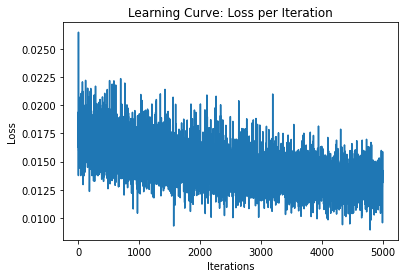

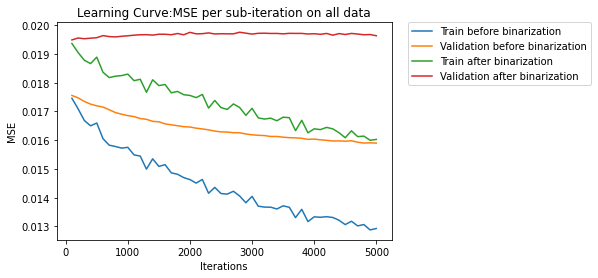

In [ ]:
plot_learning_curve(*linear_predict_model_info_1)

Surprisingly, this training didn't lead to any improvement regarding the MSE between the target frame and the decoded prediction. Moreover, it lead to overfitting, as we can infer from the graphs above.

We also tried changing few hyper-parameters without any success.

We can point out few reasons why this training failed:


*   Concatanation of the models together created a deep network which is hard to train. 
*   In this training, we expected the AE to generalize the structure of the latents into a form which is easier for the latent predictor to understand and predict. for an example: we'd like the AE to separate the location information and the shape information components, which are stored in the latent vector. Unfurtunatly, we can assume that both  models were already "baked" in their training sections and couldn't deeply change their structure.



# Test accuaracies of the final model:

Accuracy for the basic data:

In [ ]:
Test_MSE_before_bin,Test_MSE_after_bin = end2end_MSE(Autoencoder_model,linear_predict_model, test_data_rnn)
print("Basic test MSE Before Binarization:",Test_MSE_before_bin,"Basic test MSE after Binarization:",Test_MSE_after_bin)

Easy Test MSE Before Binarization: 0.012357731663541278 Easy Test MSE after Binarization: 0.013800781250000001


Accuracy for the intermediate data:

In [ ]:
Test_MSE_before_bin,Test_MSE_after_bin = end2end_MSE(Autoencoder_model,linear_predict_model, test_data_rnn)
print("Intermediate test MSE Before Binarization:",Test_MSE_before_bin,"Intermediate test MSE after Binarization:",Test_MSE_after_bin)

Intermediate test MSE Before Binarization: 0.018010787932518358 Intermediate test MSE after Binarization: 0.020090060763888886


Accuracy for the difficult data:

In [ ]:
Test_MSE_before_bin,Test_MSE_after_bin = end2end_MSE(Autoencoder_model,linear_predict_model, test_data_rnn)
print("Difficult test MSE Before Binarization:",Test_MSE_before_bin,"Difficult test MSE after Binarization:",Test_MSE_after_bin)

Difficult test MSE Before Binarization: 0.018844499783756668 Difficult test MSE after Binarization: 0.02075998263888889


We concluded the accuracies into a table below:

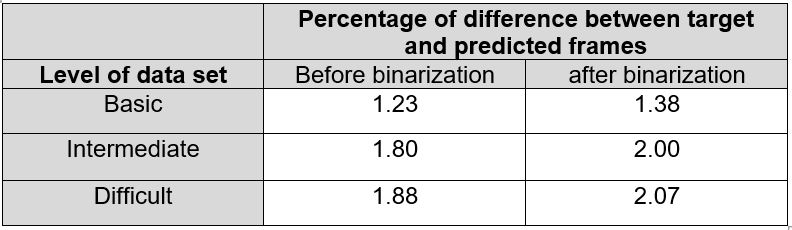

# Final Conclusions:



*   We found the importance of modifying the AE architecture regarding the main issues with the model, for an example: using another deconvolution layer and then another convolution layer in order to precisly describe the edges of the images exploiting the compression of the convolution.
*   While trying to get high accuracies, we noticed that the model related hyperparameters (latent size, hidden size in LSTM) are more important than training related hyperparameters (lr, weight decay, batch size).
*   If we had to do it all over again, we might consider a different approach of training: we'd envolve end-to-end training phase in earlier stages of training in order to adjust the AE and Latent predictor interfaces better.
*   Generally, we think that the next frame prediction task is achievable, but if the frames we are using to predict get stochastic and too complicated, the result might be disappointing.    



# Appendix: Demo Videos Creation

In [ ]:
# get the input and targets of a minibatch
start_idx =0 
stop_idx = 100
test_video_batch = test_data_rnn[start_idx:stop_idx,:,:,:] # (batch_size, num_frames,48,48)
num_of_frames = test_video_batch.shape[1]
# convert from numpy arrays to PyTorch tensors
# train_video_batch = np.reshape(test_video_batch,(num_of_frames,1,48,48)) # (6,1,48,48)
test_video_batch = np.reshape(test_video_batch,(num_of_frames*(stop_idx-start_idx),1,48,48)) # (num_of_frames*(stop_idx-start_idx),1,48,48)
Autoencoder_model.eval()
test_batch_tensor = torch.Tensor(test_video_batch)
# test_batch_tensor = torch.unsqueeze(test_batch_tensor,0)
# test_batch_tensor.transpose_(0, 1)
print(test_batch_tensor.shape)
test_latent_batch = Autoencoder_model.encoder(test_batch_tensor)   # compute encoded (num_of_frames*(stop_idx-start_idx),64)
test_latent_batch = torch.reshape(test_latent_batch,((stop_idx-start_idx),num_of_frames,64)) # test_latent_batch= ((stop_idx-start_idx),num_of_frames,64)
predicted_next_latent = linear_predict_model.forward(test_latent_batch[:,:-1,:]) # output= (100,1,64) 
print(predicted_next_latent.shape)
predicted_next_latent = torch.squeeze(predicted_next_latent,1)
print(predicted_next_latent.shape)
decoded_frames = Autoencoder_model.decoder(predicted_next_latent) #  output = (100,1,48,48)
decoded_frames = torch.squeeze(decoded_frames,1)
decoded_frames = decoded_frames.detach().numpy()
decoded_frames = np.sign(decoded_frames)*0.5 + 0.5



torch.Size([600, 1, 48, 48])
torch.Size([100, 1, 64])
torch.Size([100, 64])


In [ ]:
start_idx =0 
stop_idx = 100
test_video_batch = test_data_rnn[start_idx:stop_idx,:,:,:] # (batch_size, num_frames,48,48)
num_of_frames = test_video_batch.shape[1]
# convert from numpy arrays to PyTorch tensors

test_video_batch = np.reshape(test_video_batch,(num_of_frames*(stop_idx-start_idx),1,48,48)) # (num_of_frames*(stop_idx-start_idx),1,48,48)
Autoencoder_model.eval()
test_batch_tensor = torch.Tensor(test_video_batch)
decoded_groundtruth = Autoencoder_model.forward(test_batch_tensor)
decoded_groundtruth = torch.squeeze(decoded_groundtruth,1)
decoded_groundtruth = decoded_groundtruth.detach().numpy() #(600,48,48)
print(decoded_groundtruth.shape)
decoded_groundtruth = np.reshape(decoded_groundtruth,(stop_idx-start_idx,num_of_frames,48,48)) # (6,1,48,48)
print(decoded_groundtruth.shape)


(600, 48, 48)
(100, 6, 48, 48)


In [ ]:
from scipy.io import savemat
mdic1 = {"decoded_frames": decoded_frames}
savemat("decoded_frames.mat", mdic1)

mdic2 = {"decoded_groundtruth": decoded_groundtruth}
savemat("decoded_groundtruth.mat", mdic2)